<a href="https://colab.research.google.com/github/sellerstx1982/multimodal_damage_identification/blob/Watson/project_3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pathlib import Path
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, classification_report
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalAveragePooling2D, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the dataset
data_path = '/content/drive/MyDrive/disaster_data.pkl'
df = pd.read_pickle(data_path)
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.42352941 0.3372549 0.31764706], [0.4078...","Frank Island fire in YNP. #yellowstone , #yell...",fire,fire,damage
5297,"[[[[0.17647059 0.23137255 0.29411765], [0.2078...",ایران سوگوار کرمانشاهش شد.\n😢😢\n#کرمانشاه\nThe...,earthquake,earthquake,damage
1121,"[[[[0.10980392 0.10980392 0.10980392], [0.1098...","ACT OF PURE EVIL, this was terror attack PERIO...",war,war,damage
561,"[[[[0.24705882 0.43921569 0.23529412], [0.2196...",#rain #landslide,landslide,landslide,damage
1188,"[[[[0.88627451 0.80392157 0.7372549 ], [0.8901...",post-pizza party 🍕🔥🍕🔥🍕🔥🍕🔥🍕🔥 #sponcon #ad,non-damage,non-damage,non-damage


## Damage and Non-Damage Model, Random Image Selector

In [6]:
# Extract the 'image' column from the DataFrame and store it in X_image
X_image = df['image']

# Create an empty list to store the resized images
resized_X_image = []

# Loop through each image in the X_image list/column
for img in X_image:
    if img.shape != (250, 250, 3):

        resized_img = np.resize(img, (250, 250, 3))

        resized_X_image.append(resized_img)
    else:

        resized_X_image.append(img)

# Convert the list of resized images into a NumPy array
X_images = np.array(resized_X_image)

In [7]:
# Convert the image column to a NumPy array
X_data = np.array([np.squeeze(image, axis=0) if image.shape[0] == 1 else image for image in X_images])

y_data = df['label_3'].values  # Convert labels to NumPy array

# Split the data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42, stratify=y_data)

# Check the shapes of the training and test data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (750, 250, 250, 3)
X_test shape: (250, 250, 250, 3)
y_train shape: (750,)
y_test shape: (250,)


In [8]:
# Convert categorical labels to numeric
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [9]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3

# Define input shape
input_shape = (250, 250, 3)

# Define the input layer
inputs = Input(shape=input_shape)

# Load InceptionV3 model without the top layers and pretrained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Add fully connected layers with LeakyReLU and Dropout
x = Dense(64)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)
x = Dense(32)(x)
x = LeakyReLU(alpha=0.1)(x)

# Add the output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs, outputs)

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 250, 250, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 124, 124, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 124, 124, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 124, 124, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 122, 122, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 122, 122, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 122, 122, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 122, 122, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 122, 122, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 122, 122, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 60, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 60, 60, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 60, 60, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 60, 60, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 58, 58, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 58, 58, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 26,523,553 (101.18 MB)

 Trainable params: 4,720,769 (18.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [10]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.5717 - loss: 0.8834
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.8304 - loss: 0.3980
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9031 - loss: 0.2517
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.9408 - loss: 0.1770
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9298 - loss: 0.1542
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.9629 - loss: 0.1045
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.9781 - loss: 0.0696
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.9775 - loss: 0.0595
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9809 - loss: 0.0609
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.9809 - loss: 0.0504


In [12]:
 model.evaluate(X_test, y_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.8555 - loss: 0.6366


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


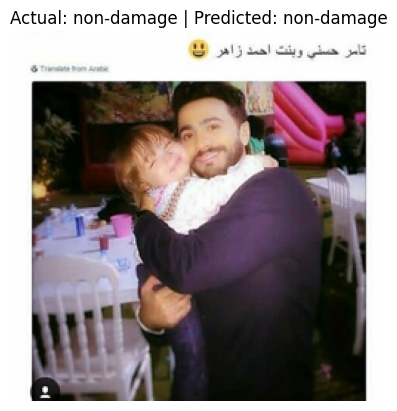

In [55]:
# Randomly select an image from the test set
random_index = random.randint(0, X_test.shape[0] - 1)

# Use the random index to select a corresponding image from X_test
random_image = X_test[random_index]

# Retrieve the actual label for the selected image by finding the index of the maximum value in the one-hot encoded label
actual_label = np.argmax(y_test[random_index])

# Make a prediction
prediction = model.predict(np.expand_dims(random_image, axis=0))
predicted_label = np.argmax(prediction)

# Map labels to readable form with a dictionary
labels = {0: 'non-damage', 1: 'damage'}

# Convert the actual and predicted label indices into their corresponding class names
actual_label_text = labels[actual_label]
predicted_label_text = labels[predicted_label]

# Display the random image with actual and predicted labels
plt.imshow(random_image)
plt.title(f'Actual: {actual_label_text} | Predicted: {predicted_label_text}')
plt.axis('off')
plt.show()


# Preprocessing

In [ ]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# main_folder = "/content/drive/MyDrive/multimodal+damage+identification+for+humanitarian+computing/multimodal/"

In [ ]:
# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Preprocessing function for images
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((250, 250))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize pixel values
#         return np.expand_dims(image, axis=0)  # Add batch dimension
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Function to load text from a file
# def load_text_file(text_path):
#     try:
#         with open(text_path, 'r', encoding='utf-8') as file:
#             return file.read()
#     except Exception as e:
#         print(f"Error reading text file {text_path}: {e}")
#         return None

In [ ]:
# # Iterate over each category subfolder in the main folder
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)
#     if os.path.isdir(subfolder_path):
#         # The image and text folders inside each category folder
#         image_folder = os.path.join(subfolder_path, 'images')
#         text_folder = os.path.join(subfolder_path, 'text')

#         # Check if both the image and text folders exist
#         if os.path.exists(image_folder) and os.path.exists(text_folder):
#             for image_file in os.listdir(image_folder):
#                 if image_file.endswith(('jpg', 'jpeg', 'png')):
#                     image_path = os.path.join(image_folder, image_file)
#                     # Construct the corresponding text file name
#                     text_file = image_file.rsplit('.', 1)[0] + '.txt'
#                     text_path = os.path.join(text_folder, text_file)

#                     # Check if the text file exists and load both image and text
#                     if os.path.exists(text_path):
#                         image = preprocess_image(image_path)
#                         if image is not None:
#                             text = load_text_file(text_path)
#                             if text is not None:
#                                 # Extract the label by splitting at the underscore and taking the first part
#                                 label = image_file.split('_', 1)[0]
#                                 images.append(image)
#                                 texts.append(text)
#                                 labels.append(label)  # Append the prefix before the first underscore as label


In [ ]:
# # images = np.array([np.array(image) for image in images])
# type(images)

In [ ]:
# print(len(images))
# print(len(texts))
# print(len(labels))

In [ ]:
# df = pd.DataFrame({'image': images, 'text': texts, 'label': labels})
# df.head()

In [ ]:
# df['label_2'] = df['label'].replace({'destruction': 'destruction',
#                                    'drought': 'drought',
#                                    'buildingcollapse': 'earthquake',
#                                    'destroyedbuilding': 'earthquake',
#                                    'earthquake': 'earthquake',
#                                    'earthquakenepal': 'earthquake',
#                                    'buildingfire': 'fire',
#                                    'forestfire': 'fire',
#                                    'forrestfire': 'fire',
#                                    'wildfires': 'fire',
#                                    'accrafloods': 'flood',
#                                    'floodwater': 'flood',
#                                    'hurricaneharvey': 'hurricane',
#                                    'hurricaneirma': 'hurricane',
#                                    'hurricanematthew': 'hurricane',
#                                    'hurricanesandy': 'hurricane',
#                                    'sandydamage': 'hurricane',
#                                    'treefalling': 'hurricane',
#                                    'treesfalling': 'hurricane',
#                                    'windstorm': 'hurricane',
#                                    'landslide': 'landslide',
#                                    'disaster': 'naturaldisaster',
#                                    'disasters': 'naturaldisaster',
#                                    'naturaldamage': 'naturaldisaster',
#                                    'naturaldisaster': 'naturaldisaster',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'war',
#                                    'isiscrimes': 'war',
#                                    'yemencrisis': 'war',
#                                    'suicidebombing': 'war',
#                                    'victimsofwar': 'war',
#                                    'war': 'war',
#                                    'syriawarcrimes': 'war',
#                                    'warsyria': 'war',
#                                    'yemencrisis': 'war',
#                                    'wreckedcar': 'wreckedcar',
#                                    })

In [ ]:
# df['label_3'] = df['label'].replace({'destruction': 'damage',
#                                    'drought': 'damage',
#                                    'buildingcollapse': 'damage',
#                                    'destroyedbuilding': 'damage',
#                                    'earthquake': 'damage',
#                                    'earthquakenepal': 'damage',
#                                    'buildingfire': 'damage',
#                                    'forestfire': 'damage',
#                                    'forrestfire': 'damage',
#                                    'wildfires': 'damage',
#                                    'accrafloods': 'damage',
#                                    'floodwater': 'damage',
#                                    'hurricaneharvey': 'damage',
#                                    'hurricaneirma': 'damage',
#                                    'hurricanematthew': 'damage',
#                                    'hurricanesandy': 'damage',
#                                    'sandydamage': 'damage',
#                                    'treefalling': 'damage',
#                                    'treesfalling': 'damage',
#                                    'windstorm': 'damage',
#                                    'landslide': 'damage',
#                                    'disaster': 'damage',
#                                    'disasters': 'damage',
#                                    'naturaldamage': 'damage',
#                                    'naturaldisaster': 'damage',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'damage',
#                                    'isiscrimes': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'suicidebombing': 'damage',
#                                    'victimsofwar': 'damage',
#                                    'war': 'damage',
#                                    'syriawarcrimes': 'damage',
#                                    'warsyria': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'wreckedcar': 'damage',

#                                    })

In [ ]:
df.head()

KeyboardInterrupt: 

In [ ]:
df['label_3'].value_counts()

In [ ]:
# sample_df = df.sample(n=1000, random_state=42)
# sample_df.info()

In [ ]:
# sample_df['label_3'].value_counts()

In [ ]:
df.head()

#Label and Split Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


In [ ]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.42352941 0.3372549 0.31764706], [0.4078...","Frank Island fire in YNP. #yellowstone , #yell...",fire,fire,damage
5297,"[[[[0.17647059 0.23137255 0.29411765], [0.2078...",ایران سوگوار کرمانشاهش شد.\n😢😢\n#کرمانشاه\nThe...,earthquake,earthquake,damage
1121,"[[[[0.10980392 0.10980392 0.10980392], [0.1098...","ACT OF PURE EVIL, this was terror attack PERIO...",war,war,damage
561,"[[[[0.24705882 0.43921569 0.23529412], [0.2196...",#rain #landslide,landslide,landslide,damage
1188,"[[[[0.88627451 0.80392157 0.7372549 ], [0.8901...",post-pizza party 🍕🔥🍕🔥🍕🔥🍕🔥🍕🔥 #sponcon #ad,non-damage,non-damage,non-damage


In [ ]:
X_image = df['image']
X_text = df['text']
y = df['label_3']

In [ ]:
new_X_image = []
for row in X_image:
    for image in row:
        new_X_image.append(image)

new_X_image[0]

X_image = [np.array(img).astype(np.float32) for img in new_X_image]

In [ ]:
resized_X_image = []

for img in X_image:
    if img.shape != (250, 250, 3):

        resized_img = np.resize(img, (250, 250, 3))

        resized_X_image.append(resized_img)
    else:

        resized_X_image.append(img)

X_image = np.array(resized_X_image)

In [ ]:
print(X_image.shape)
print(X_image[0].shape)

(1000, 250, 250, 3)
(250, 250, 3)


In [ ]:
y = y.replace({'damage': 1, 'non-damage': 0})

<ipython-input-11-29e6a47d55c9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'damage': 1, 'non-damage': 0})


In [ ]:
X_train_image, X_test_image, X_train_text, X_test_text, y_train, y_test = train_test_split(X_image, X_text, y, test_size=0.2, random_state=42)


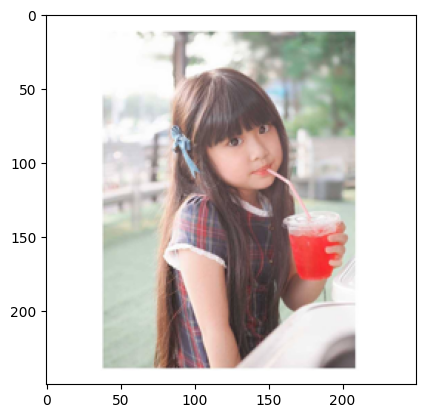

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((X_train_image[55]*255).astype(np.uint8))